In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm
from sklearn.cluster import *
%matplotlib inline

In [2]:
import time
st = time.time()

### Import formatted samples from .csv file

In [3]:
df = pd.read_csv("BlumPecha2014_formatted_data.csv",delimiter=',')
df.head()

,Sample 4,Sample 5,Sample 6,Sample 7,Sample 9
0,123.0,124.0,125.0,125.0,127.0
1,312.0,315.0,311.0,307.0,310.0
2,123.2,377.4,110.6,122.5,112.8
3,123.7,415.5,112.7,336.4,165.8
4,128.3,427.9,113.2,369.1,177.6


,Sample 4,Sample 5,Sample 6,Sample 7,Sample 9
0,123.0,124.0,125.0,125.0,127.0
1,312.0,315.0,311.0,307.0,310.0


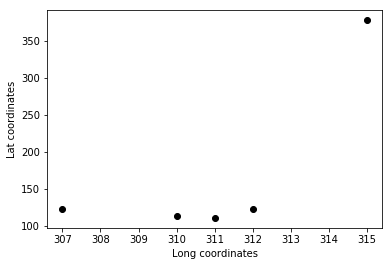

In [4]:
# plot sample locations
fig, ax = plt.subplots()
ax.set_xlabel('Long coordinates')
ax.set_ylabel('Lat coordinates')
ax.plot(df.iloc[[1]],df.iloc[[2]],'ko')

df[0:2]

### Generate KDEs for samples
Build new dataframe of samples kde series

In [7]:
def build_KDE(ages,bw,max_age_roundup):
    
    ages = np.array(ages[~np.isnan(ages)]) #remove nans and convert to array
    x_range = np.arange(0,max_age_roundup,1) #sampled every 1 spacing
    KDE_bandwidths = [bw for i in ages] # set bandwidth for each age
    
    sum_pdf = x_range-x_range
    for i in range(len(ages)):
        sum_pdf = sum_pdf + norm.pdf(x=x_range,loc=ages[i],scale=KDE_bandwidths[i])
        norm_sum_pdf = sum_pdf / len(ages)
    return norm_sum_pdf


max_age = max(df[2:].max())
max_age_roundup = int(math.ceil(max_age/500.0))*500 # to nearest 500
bw = 30
KDE_df = pd.DataFrame(data=None, columns=df.columns)

for col in df:
    KDE_series = pd.Series(build_KDE(df[col][2:], bw, max_age_roundup))
    KDE_df[col] = KDE_series
    #print(df[col].apply(build_KDE)) for apply stuff every row

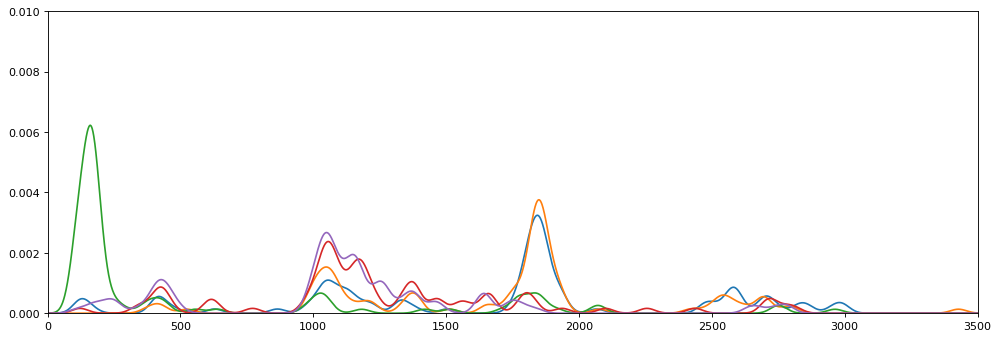

In [8]:
fig=plt.figure(figsize=(15, 5), dpi=80)
plt.xlim(0,max_age_roundup)
plt.ylim(0,0.01)

for col in KDE_df:
    plt.plot(KDE_df[col])

### Build dissimilarity matrix

In [9]:
def calc_stat(x,y,stat):
    x = np.array(x)
    y = np.array(y)
    
    if stat=='likeness':
        M = abs(x-y)
        s = sum(M)/2
        return s
    
    if stat=='similarity':
        if np.array_equal(x,y):
            s = 0
        else:
            S = np.sqrt(x*y)
            s = 1-sum(S)
        return s
        
    if stat=='R2':
        xmean = np.mean(x)
        ymean = np.mean(y)
        xcov = np.zeros(len(x))
        ycov = np.zeros(len(y))
        
        for i in range(len(x)):
            xcov[i] = x[i] - xmean
        for i in range(len(x)):
            ycov[i] = y[i] - ymean
        numerator = sum(xcov*ycov)
        
        sumxcov2 = sum(xcov*xcov)
        sumycov2 = sum(ycov*ycov)
        mult2 = sumxcov2*sumycov2
        denominator = np.sqrt(mult2)

        r = numerator/denominator
        r2 = r*r
        s = 1-r2
        return s

In [10]:
n = len(KDE_df.columns)
diss = np.zeros((n,n))
stat = 'R2'

for i in range(n):
    for j in range(n):
        diss[i,j] = calc_stat(KDE_df.iloc[:,i], KDE_df.iloc[:,j],stat)

In [11]:
diss

array([[ 0.        ,  0.08736374,  0.9856398 ,  0.88197303,  0.92295928],
       [ 0.08736374,  0.        ,  0.99944111,  0.84639608,  0.89686754],
       [ 0.9856398 ,  0.99944111,  0.        ,  0.99985855,  0.99261556],
       [ 0.88197303,  0.84639608,  0.99985855,  0.        ,  0.12916509],
       [ 0.92295928,  0.89686754,  0.99261556,  0.12916509,  0.        ]])

### Agglomerative clustering

In [15]:
no_clusters = 2
model = AgglomerativeClustering(linkage='complete',
                               affinity='precomputed',
                               compute_full_tree=False,
                               n_clusters=no_clusters)

In [16]:
m = model.fit(diss)

In [17]:
m.labels_

array([0, 0, 1, 0, 0], dtype=int64)

### Plot examples